In [107]:
#Data Cleaning and Organizing
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')


#pre processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, f1_score, plot_confusion_matrix, accuracy_score, precision_score, recall_score

In [71]:
#each data set, not included in github
buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
samSub = pd.read_csv('energyCSV/sample_submission.csv')
test = pd.read_csv('energyCSV/test.csv')
train = pd.read_csv('energyCSV/train.csv')
weatherTest = pd.read_csv('energyCSV/weather_test.csv')
weatherTrain = pd.read_csv('energyCSV/weather_train.csv')

In [72]:
# Function to reduce the DF size
# Code from Kaggle user Koustav Banerjee

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [73]:
#Running the function to reduce the memory
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

weatherTrain = reduce_mem_usage(weatherTrain)
weatherTest = reduce_mem_usage(weatherTest)
buildMetData = reduce_mem_usage(buildMetData)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


## Pre-processing

In [74]:
print(train.info(), test.info(), weatherTrain.info(), weatherTest.info(), buildMetData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int16  
 1   meter          int8   
 2   timestamp      object 
 3   meter_reading  float32
dtypes: float32(1), int16(1), int8(1), object(1)
memory usage: 289.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int32 
 1   building_id  int16 
 2   meter        int8  
 3   timestamp    object
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 596.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int8   
 1   timestamp           139773 non-null  object 


The 'timestamp' coloumns in 'train', 'test', 'weatherTrain', 'weatherTest' - as well as the column 'primary_use' in BuildMetData - are currently an onject type. Need to change those formats into something more usable.

In [75]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

weatherTrain['timestamp'] = pd.to_datetime(weatherTrain['timestamp'])
weatherTest['timestamp'] = pd.to_datetime(weatherTest['timestamp'])

buildMetData['primary_use'] = buildMetData['primary_use'].astype('category')

In [76]:
print(train.info(), test.info(), weatherTrain.info(), weatherTest.info(), buildMetData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   row_id       int32         
 1   building_id  int16         
 2   meter        int8          
 3   timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1)
memory usage: 596.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------

Much better. Now, as the data is currently 'timestamp presents itself as a single moment in time. A single hour for every day. this can be broken into further cartegories: 'hour', 'day', 'weekday', & 'month'. This recategorizing could help us find trends in specific, months, days, or even hours for the data to find trends in.

In [77]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


In [78]:
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

test["hour"] = test["timestamp"].dt.hour
test["day"] = test["timestamp"].dt.day
test["weekend"] = test["timestamp"].dt.weekday
test["month"] = test["timestamp"].dt.month

In [79]:
train

,building_id,meter,timestamp,meter_reading,hour,day,weekend,month
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1
...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,31,5,12
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,31,5,12
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,31,5,12
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,31,5,12


Neat-o. Next, concatenating train & test on BuildMetData and the respective weather df so that train and test have all the infomation to train on.

In [80]:
#Merging Train, BuildMetData, weatherTrain
trainBuild = train.merge(buildMetData, on=['building_id'], how='left')
train = trainBuild.merge(weatherTrain, on=['site_id','timestamp'], how='left')

#Merging Test, BuildMetData, weatherTest
testBuild = test.merge(buildMetData, on=['building_id'], how='left')
test = testBuild.merge(weatherTest, on=['site_id','timestamp'], how='left')

In [81]:
train

,building_id,meter,timestamp,meter_reading,hour,day,weekend,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,31,5,12,15,Entertainment/public assembly,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,31,5,12,15,Education,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,31,5,12,15,Entertainment/public assembly,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,31,5,12,15,Lodging/residential,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
samSub = pd.read_csv('energyCSV/sample_submission.csv')
test = pd.read_csv('energyCSV/test.csv')
train = pd.read_csv('energyCSV/train.csv')
weatherTest = pd.read_csv('energyCSV/weather_test.csv')
weatherTrain = pd.read_csv('energyCSV/weather_train.csv')

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
weatherTrain['timestamp'] = pd.to_datetime(weatherTrain['timestamp'])
weatherTest['timestamp'] = pd.to_datetime(weatherTest['timestamp'])
buildMetData['primary_use'] = buildMetData['primary_use'].astype('category')

train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month
test["hour"] = test["timestamp"].dt.hour
test["day"] = test["timestamp"].dt.day
test["weekend"] = test["timestamp"].dt.weekday
test["month"] = test["timestamp"].dt.month

temp_df = train[['building_id']]
temp_df = temp_df.merge(buildMetData, on=['building_id'], how='left')
del temp_df['building_id']
trainEx = pd.concat([train, temp_df], axis=1)

temp_df = test[['building_id']]
temp_df = temp_df.merge(buildMetData, on=['building_id'], how='left')
del temp_df['building_id']
testEx = pd.concat([test, temp_df], axis=1)

del temp_df

temp_df = trainEx[['site_id','timestamp']]
temp_df = temp_df.merge(weatherTrain, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
trainEx = pd.concat([train, temp_df], axis=1)

temp_df = testEx[['site_id','timestamp']]
temp_df = temp_df.merge(weatherTest, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
testEx = pd.concat([test, temp_df], axis=1)

del temp_df

There are a couple things that need to happen until we can call this data 'clean enough'

    - Label encode 'primary_use'
    - drop 'timestamp', 'row_id_ & 'site_id' as they are now unnecessary
    - drop 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', & 'floor_count' as they are either
    unnecessary or will skew the data more than their worth to fix worth.

In [100]:
#'primary_use' needs to be label encoded to run a model
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

le = LabelEncoder()

train['primary_use'] = le.fit_transform(train['primary_use']).astype(np.int8)
test['primary_use'] = le.fit_transform(test['primary_use']).astype(np.int8)

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4202848 entries, 0 to 20214574
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int16  
 1   meter            int8   
 2   meter_reading    float32
 3   hour             int64  
 4   day              int64  
 5   weekend          int64  
 6   month            int64  
 7   primary_use      int8   
 8   square_feet      int32  
 9   year_built       float16
 10  air_temperature  float16
 11  cloud_coverage   float16
 12  dew_temperature  float16
dtypes: float16(4), float32(1), int16(1), int32(1), int64(4), int8(2)
memory usage: 240.5 MB


array([[<AxesSubplot:title={'center':'building_id'}>,
        <AxesSubplot:title={'center':'meter'}>,
        <AxesSubplot:title={'center':'meter_reading'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'weekend'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'site_id'}>],
       [<AxesSubplot:title={'center':'primary_use'}>,
        <AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'year_built'}>,
        <AxesSubplot:title={'center':'floor_count'}>],
       [<AxesSubplot:title={'center':'air_temperature'}>,
        <AxesSubplot:title={'center':'cloud_coverage'}>,
        <AxesSubplot:title={'center':'dew_temperature'}>,
        <AxesSubplot:title={'center':'precip_depth_1_hr'}>],
       [<AxesSubplot:title={'center':'sea_level_pressure'}>,
        <AxesSubplot:title={'center':'wind_direction'}>,
        <AxesSubplot:title={'ce

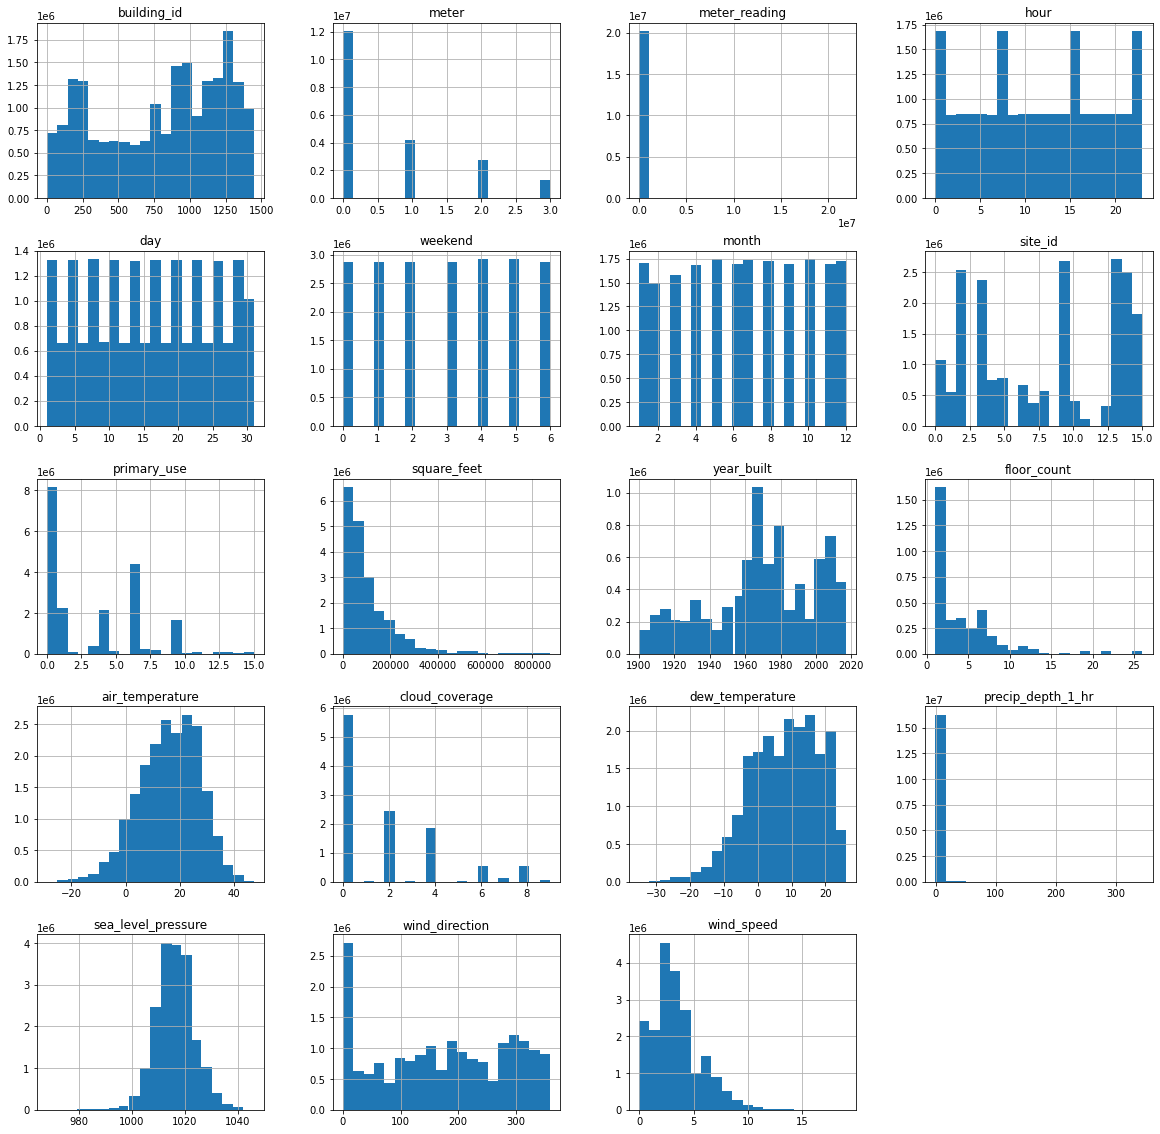

In [83]:
#Taking a quick look at the full data before we remove some things
train.hist(figsize=(20,20), bins=20)

In [84]:
train

,building_id,meter,timestamp,meter_reading,hour,day,weekend,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,31,5,12,15,1,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,31,5,12,15,0,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,31,5,12,15,1,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,31,5,12,15,4,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [85]:
dropCols = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'site_id', 'floor_count']

train = train.drop(dropCols, axis = 1)
test = test.drop(dropCols + ['row_id'], axis = 1)

In [86]:
#Data Prep
scaler = StandardScaler()

cats = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]
nums = ["square_feet", "year_built", "air_temperature","dew_temperature", "cloud_coverage"]
featCols = cats + nums

#have some inf types that need to be dealt with. Just dropping them fro simplicity.


train = train.dropna()
test = test.dropna()

In [87]:
test.isnull().sum()

building_id        0
meter              0
timestamp          0
hour               0
day                0
weekend            0
month              0
primary_use        0
square_feet        0
year_built         0
air_temperature    0
cloud_coverage     0
dew_temperature    0
dtype: int64

In [88]:
train

,building_id,meter,timestamp,meter_reading,hour,day,weekend,month,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,7432,2008.0,25.000000,6.0,20.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,2720,2004.0,25.000000,6.0,20.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,5376,1991.0,25.000000,6.0,20.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,23685,2002.0,25.000000,6.0,20.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,116607,1975.0,25.000000,6.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20214570,651,0,2016-12-31 23:00:00,47.993999,23,31,5,12,8,306140,2007.0,12.796875,2.0,3.300781
20214571,652,0,2016-12-31 23:00:00,67.976501,23,31,5,12,0,150887,1959.0,12.796875,2.0,3.300781
20214572,653,0,2016-12-31 23:00:00,808.492004,23,31,5,12,0,420885,1930.0,12.796875,2.0,3.300781
20214573,654,0,2016-12-31 23:00:00,45.194199,23,31,5,12,0,43910,1912.0,12.796875,2.0,3.300781


In [89]:
#Data Prep
train = train.dropna()
train = train.drop(columns = ['timestamp'], axis = 1)

In [104]:
#Scales my data
scaler = StandardScaler()
train['year_built'] = le.fit_transform(train['year_built']).astype(np.int8)
train['air_temperature'] = le.fit_transform(train['air_temperature']).astype(np.int8)
train['cloud_coverage'] = le.fit_transform(train['cloud_coverage']).astype(np.int8)
train['dew_temperature'] = le.fit_transform(train['dew_temperature']).astype(np.int8)
train['meter_reading'] = le.fit_transform(train['meter_reading']).astype(np.int8)
#Ecoder to categorize onto cols 'workType' and 'smokingStatus'

xCols = [c for c in train.columns.to_list() if c not in ['meter_reading']]

x = train[xCols]
y = train['meter_reading']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.transform(xTest)

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4202848 entries, 0 to 20214574
Data columns (total 13 columns):
 #   Column           Dtype
---  ------           -----
 0   building_id      int16
 1   meter            int8 
 2   meter_reading    int8 
 3   hour             int64
 4   day              int64
 5   weekend          int64
 6   month            int64
 7   primary_use      int8 
 8   square_feet      int32
 9   year_built       int8 
 10  air_temperature  int8 
 11  cloud_coverage   int8 
 12  dew_temperature  int8 
dtypes: int16(1), int32(1), int64(4), int8(7)
memory usage: 212.4 MB


In [108]:
logReg = LogisticRegression(random_state = 123, class_weight = 'balanced~', multi_class='auto')
logReg.fit(xTrainScaled, yTrain)

yPredTrain = logReg.predict(xTrainScaled)
yPredTest = logReg.predict(xTestScaled)

#plot_confusion_matrix(logReg, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain)}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest)}")
print('-----')
print('0 is "Not at risk of a stroke"')
print('1 is "At risk of a stroke"')

Accuracy Train Score: 0.0526611664869733
Accuracy Test Score: 0.052826365956710454
-----


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [113]:
GBClass = GradientBoostingClassifier()
GBClass.fit(xTrainScaled, yTrain)

yPredTrain = logReg.predict(xTrainScaled)
yPredTest = logReg.predict(xTestScaled)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain)}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest)}")
print('-----')
print('0 is "Not at risk of a stroke"')
print('1 is "At risk of a stroke"')

KeyboardInterrupt: 

In [118]:
categoricals = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage","dew_temperature"]
feat_cols = categoricals + numericals

In [119]:
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = False, random_state = 42)
error = 0
models = []
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    
    #Splitting The DF Into Train Test Split
    train_X = train[feat_cols].iloc[train_index]
    val_X = train[feat_cols].iloc[val_index]
    train_y = test.iloc[train_index]
    val_y = test.iloc[val_index]
    
    #Training The Model
    lgb_train = lgb.Dataset(train_X, train_y > 0)
    lgb_eval = lgb.Dataset(val_X, val_y > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    #we did this so that we only consider positive vals and no dta leakage would be there
    lgb_train = lgb.Dataset(train_X[train_y > 0], train_y[train_y > 0]) 
    lgb_eval = lgb.Dataset(val_X[val_y > 0] , val_y[val_y > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    y_pred = (gbm_class.predict(val_X, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(val_X, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (val_y)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (val_y))))
    break
print(error)

3362278 3362279


TypeError: Invalid comparison between dtype=datetime64[ns] and int